In [ ]:
# Dose map from neutrons

This task simulates dose from a pulse of neutrons on a regular mesh.

The regular mesh values are then used to create a dose map showing dose limits

In [4]:
# import plotly.graph_objects as go
import openmc
from pathlib import Path
# Setting the cross section path to the correct location in the docker image.
# If you are running this outside the docker image you will have to change this path to your local cross section path.
openmc.config['cross_sections'] = Path.home() / 'nuclear_data' / 'cross_sections.xml'

We define the materials used in the simulation, we are using air and concrete.

In [5]:
mat_air = openmc.Material(name="air")
mat_air.add_element("N", 0.784431)
mat_air.add_element("O", 0.210748)
mat_air.add_element("Ar", 0.0046)
mat_air.set_density("g/cc", 0.001205)

mat_concrete = openmc.Material(name='concrete')
mat_concrete.add_element("H",0.168759)
mat_concrete.add_element("C",0.001416)
mat_concrete.add_element("O",0.562524)
mat_concrete.add_element("Na",0.011838)
mat_concrete.add_element("Mg",0.0014)
mat_concrete.add_element("Al",0.021354)
mat_concrete.add_element("Si",0.204115)
mat_concrete.add_element("K",0.005656)
mat_concrete.add_element("Ca",0.018674)
mat_concrete.add_element("Fe",0.00426)
mat_concrete.set_density("g/cm3", 2.3)

materials_continuous_xs = openmc.Materials([mat_air, mat_concrete])

Then we define the geometry, which is just a shielded room

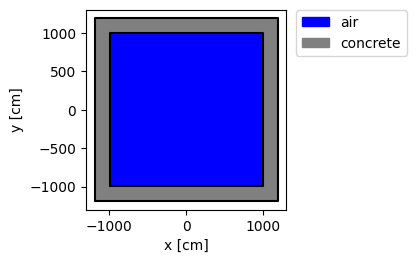

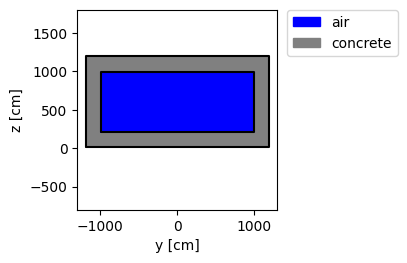

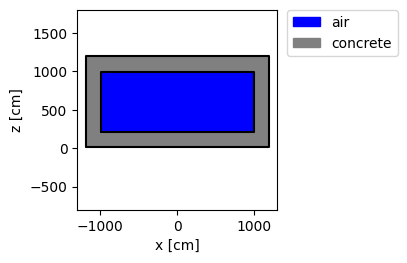

In [ ]:

lower_ceiling = openmc.ZPlane(z0=1000)
upper_ceiling = openmc.ZPlane(z0=1200, boundary_type='vacuum')
upper_floor = openmc.ZPlane(z0=200)
lower_floor = openmc.ZPlane(z0=0, boundary_type='vacuum')

left_wall_outer_wall = openmc.XPlane(x0=-1200, boundary_type='vacuum')
right_wall_outer_wall = openmc.XPlane(x0=1200, boundary_type='vacuum')
left_wall_inner_wall = openmc.XPlane(x0=-1000)
right_wall_inner_wall = openmc.XPlane(x0=1000)

top_wall_outer_wall = openmc.YPlane(y0=1200, boundary_type='vacuum')
lower_wall_outer_wall = openmc.YPlane(y0=-1200, boundary_type='vacuum')
top_wall_inner_wall = openmc.YPlane(y0=1000)
lower_wall_inner_wall = openmc.YPlane(y0=-1000)

left_region = +left_wall_outer_wall & -left_wall_inner_wall & -top_wall_inner_wall & +lower_wall_inner_wall & -lower_ceiling & +upper_floor
right_region = -right_wall_outer_wall & +right_wall_inner_wall & -top_wall_inner_wall & +lower_wall_inner_wall & -lower_ceiling & +upper_floor
top_region = -top_wall_outer_wall & +top_wall_inner_wall & +left_wall_outer_wall & -right_wall_outer_wall & -lower_ceiling & +upper_floor
lower_region = +lower_wall_outer_wall & -lower_wall_inner_wall & +left_wall_outer_wall & -right_wall_outer_wall & -lower_ceiling & +upper_floor

inner_region = +left_wall_inner_wall & -right_wall_inner_wall & -top_wall_inner_wall & +lower_wall_inner_wall & -lower_ceiling & +upper_floor

floor = -upper_floor & +lower_floor & +left_wall_outer_wall & -right_wall_outer_wall & -top_wall_outer_wall & +lower_wall_outer_wall
celing = -upper_ceiling & +lower_ceiling & +left_wall_outer_wall & -right_wall_outer_wall & -top_wall_outer_wall & +lower_wall_outer_wall
wall_cell = openmc.Cell(name='wall_cell', region =  lower_region | right_region | top_region | left_region)
wall_cell.fill = mat_concrete
floor_cell = openmc.Cell(name='floor', region =  floor)
floor_cell.fill = mat_concrete
celing_cell = openmc.Cell(name='celing', region =  celing)
celing_cell.fill = mat_concrete
inner_cell = openmc.Cell(name='inner_cell', region=inner_region)
inner_cell.fill = mat_air

# left_region.plot()
my_geometry = openmc.Geometry([wall_cell, inner_cell, floor_cell, celing_cell])
import matplotlib.pyplot as plt
my_geometry.plot(
    basis='xy',
    origin=(0,0,500),
    width=(2600, 2600),
    outline=True,
    legend=True,
    color_by='material',
    colors={
        mat_air: 'blue',
        mat_concrete: 'gray',
    },
)
my_geometry.plot(
    basis='yz',
    origin=(0,0,500),
    width=(2600, 2600),
    outline=True,
    legend=True,
    color_by='material',
    colors={
        mat_air: 'blue',
        mat_concrete: 'gray',
    },
)
my_geometry.plot(
    basis='xz',
    origin=(0,0,500),
    width=(2600, 2600),
    outline=True,
    legend=True,
    color_by='material',
    colors={
        mat_air: 'blue',
        mat_concrete: 'gray',
    },
)
plt.show()
plt.show()

In [ ]:

# 14MeV point source
source = openmc.IndependentSource()
source.angle = openmc.stats.Isotropic()
source.energy = openmc.stats.Discrete([14e6], [1])
source.space = openmc.stats.Point((0.0, 50.0, 50.0))


In [ ]:

# Instantiate a Settings object
my_settings = openmc.Settings()
# when running a mesh tally simulation you might want to tell openmc not to save
# the tallies.out file which is a ASCII file containing the tally results.
# for mesh tallies this can get very large and take a long time to write.
# the statepoint.h5 is smaller and quicker as it is a binary file
my_settings.output = {"tallies": False}
my_settings.batches = 2
my_settings.particles = 500000
my_settings.run_mode = "fixed source"
my_settings.source = source


In [ ]:

# these are the dose coefficients coded into openmc
# originally from ICRP https://journals.sagepub.com/doi/10.1016/j.icrp.2011.10.001
energy_bins_n, dose_coeffs_n = openmc.data.dose_coefficients(
    particle="neutron",
    geometry="ISO",  # we are using the ISO direction as this is a dose field with dose
)
energy_function_filter_n = openmc.EnergyFunctionFilter(energy_bins_n, dose_coeffs_n)
energy_function_filter_n.interpolation = "cubic"  # cubic interpolation is recommended by ICRP

# just getting the dose for neutrons, not photons or other particles
neutron_particle_filter = openmc.ParticleFilter("neutron")

mesh = openmc.RegularMesh().from_domain(my_geometry, dimension=(30, 30, 30))
mesh_filter = openmc.MeshFilter(mesh)

# Create tally to score dose
dose_cell_tally = openmc.Tally(name="neutron_dose_on_mesh")
# note that the EnergyFunctionFilter is included as a filter
dose_cell_tally.filters = [
    mesh_filter,
    neutron_particle_filter,
    energy_function_filter_n,
]
dose_cell_tally.scores = ["flux"]
my_tallies = openmc.Tallies([dose_cell_tally])


In [ ]:

model = openmc.Model(my_geometry, my_materials, my_settings, my_tallies)

statepoint_filename = model.run()


In [ ]:

# makes use of a context manager "with" to automatically close the statepoint file
with openmc.StatePoint(statepoint_filename) as statepoint:
    my_mesh_tally_result = statepoint.get_tally(name="neutron_dose_on_mesh")

# tally.mean is in units of pSv-cm3/source neutron
# multiplication by neutrons_per_second changes units to neutron to pSv-cm3/second
neutrons_per_second = 1e8  # units of neutrons per second

# multiplication by pico_to_milli converts from (pico) pSv/second to (milli) mSv/second
pico_to_milli = 1e-9

# exports the mesh tally result to a vtk file with unit conversion
mesh.write_data_to_vtk(
    datasets={
        "Dose [milli Sv per second]": my_mesh_tally_result.mean.flatten()
        * neutrons_per_second
        * pico_to_milli,
    },
    volume_normalization=True,  # this converts from dose-cm3/second to dose/second
    filename="dose_on_mesh.vtk",
)


In [ ]:

# this part of the script plots the images, so these imports are only needed to plot
import openmc_geometry_plot  # extends openmc.Geometry class with plotting functions
import regular_mesh_plotter  # extends openmc.Mesh class with plotting functions
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

# gets a 2d slice of data to later plot
data_slice = mesh.slice_of_data(dataset=my_mesh_tally_result.mean, view_direction="x")

data_slice = data_slice * neutrons_per_second * pico_to_milli

plot_1 = plt.imshow(
    data_slice,
    extent=mesh.bounding_box.extent['xy'],
    interpolation=None,
    norm=LogNorm(
        vmin=1e-12,  # trims out the lower section of the colors
        vmax=max(data_slice.flatten()),
    ),
)
cbar = plt.colorbar(plot_1)
cbar.set_label(f"Dose [milli Sv per second]")


# gets unique levels for outlines contour plot and for the color scale
material_ids = my_geometry.get_slice_of_material_ids(view_direction="x")
# gets unique levels for outlines contour plot and for the color scale
levels = np.unique([item for sublist in material_ids for item in sublist])

plt.contour(
    material_ids,
    origin="upper",
    colors="k",
    linestyles="solid",
    levels=levels,
    linewidths=2.0,
    extent=my_geometry.bounding_box.extent['xy'],
)
xlabel, ylabel = my_geometry.get_axis_labels(view_direction="x")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title('Dose map showing some shielding of the source')


plt.show()